In [4]:
pip install xgboost

MAE: 445.07
RMSE: 3994.83


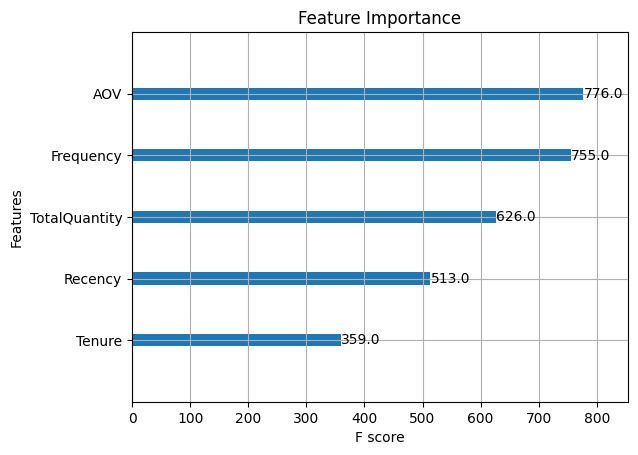

Segment
High      1473
Medium    1433
Low       1432
Name: count, dtype: int64


In [5]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# 📥 Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# 🧹 Data Cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# 🧠 Create 'TotalPrice' Column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 📆 Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 📅 Reference date for Recency
ref_date = df['InvoiceDate'].max()

# 📊 Aggregate Metrics per Customer
clv_data = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (ref_date - x.max()).days,
                    lambda x: (x.max() - x.min()).days],
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
})

clv_data.columns = ['Recency', 'Tenure', 'Frequency', 'TotalQuantity', 'Monetary']
clv_data['AOV'] = clv_data['Monetary'] / clv_data['Frequency']  # Avg Order Value

# 🎯 Target Variable: Total Monetary Value
X = clv_data[['Recency', 'Tenure', 'Frequency', 'TotalQuantity', 'AOV']]
y = clv_data['Monetary']

# ✂️ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🤖 Model Training – XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 🧮 Predictions
y_pred = model.predict(X_test)

# 📉 Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# 📈 Feature Importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

# 📤 Save Predictions
clv_data['Predicted_CLV'] = model.predict(X)
clv_data[['Recency', 'Tenure', 'Frequency', 'AOV', 'Monetary', 'Predicted_CLV']].to_csv('predicted_clv.csv')

# 🎯 Customer Segmentation by Predicted CLV
quantiles = clv_data['Predicted_CLV'].quantile([0.33, 0.66])
def segment(x):
    if x <= quantiles[0.33]:
        return 'Low'
    elif x <= quantiles[0.66]:
        return 'Medium'
    else:
        return 'High'

clv_data['Segment'] = clv_data['Predicted_CLV'].apply(segment)

# 📊 Segment Distribution
print(clv_data['Segment'].value_counts())

# 📁 Save with Segments
clv_data.to_csv('customer_segments_clv.csv')
